In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import trange
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
# dataset load
data = pd.read_csv("/home/dataset/complete_dataset.csv")
data = pd.DataFrame(data.loc[:, ["PM-2.5", "일시"]])
data["일시"] = pd.to_datetime(data["일시"])
data.index = data["일시"]
del data["일시"]
data.head()

PM-2.5
일시                
2018-04-01    27.0
2018-04-02    21.0
2018-04-03    16.0
2018-04-04     4.0
2018-04-05     3.0

In [3]:
class StatefulLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super().__init__()
    self.reset_state()
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
    self.head = nn.Linear(hidden_size, output_size)

  def reset_state(self, state=None):
    self.state = state

  def forward(self, x):
    assert x.dim() == 2   # (sequence_length, input_size)
    if self.state is None:
      x, (hn, cn) = self.rnn(x)   # state will be set to be zeros by default
    else:
      x, (hn, cn) = self.rnn(x, self.state)   # pass the saved state
    # x.shape == (sequence_length, hidden_size)
    self.reset_state((hn.detach(), cn.detach()))   # save the state
    x = self.head(x)  # (sequence_length, hidden_size) -> (sequence_length, output_size)
    return x

  def predict(self, x0, steps, state=None):
    if state is not None:
      self.reset_state(state)
    output = []
    x = x0.reshape(1,-1)
    for i in range(steps): # 한 칸씩 옆으로 이동
      x = self.forward(x)
      output.append(x)
    return torch.concat(output, 0) #output의 맨 마지막 녀석들만 따오도록

In [27]:
tst_size = 200

data = data.dropna()

trn, tst = data[:-tst_size], data[-tst_size:]

scaler = MinMaxScaler()

trn_scaled, tst_scaled = trn.copy(), tst.copy()
trn_scaled = scaler.fit_transform(trn.to_numpy(dtype=np.float32))
tst_scaled = scaler.transform(tst.to_numpy(dtype=np.float32))


In [28]:
batch_size = 64
trn_x = torch.tensor(trn_scaled[:-1]).split(batch_size)
trn_y = torch.tensor(trn_scaled[1:]).split(batch_size)

tst_y = torch.tensor(tst_scaled)

trn_x[0].shape, trn_y[0].shape

(torch.Size([64, 1]), torch.Size([64, 1]))

In [29]:
trn_x[0]

tensor([[0.1778],
        [0.1333],
        [0.0963],
        [0.0074],
        [0.0000],
        [0.1111],
        [0.0889],
        [0.0370],
        [0.1185],
        [0.0815],
        [0.0889],
        [0.0370],
        [0.0370],
        [0.0222],
        [0.0889],
        [0.0889],
        [0.1481],
        [0.1556],
        [0.2148],
        [0.3185],
        [0.2000],
        [0.0815],
        [0.0074],
        [0.0074],
        [0.1111],
        [0.1407],
        [0.2296],
        [0.2074],
        [0.1630],
        [0.3481],
        [0.2593],
        [0.1852],
        [0.0519],
        [0.0667],
        [0.0815],
        [0.0148],
        [0.0741],
        [0.0074],
        [0.0148],
        [0.0963],
        [0.1852],
        [0.0889],
        [0.0444],
        [0.3111],
        [0.3185],
        [0.1407],
        [0.0296],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0370],
        [0.1037],
        [0.0222],
        [0.1259],
        [0.2000],
        [0

In [30]:
trn_y[0]

tensor([[0.1333],
        [0.0963],
        [0.0074],
        [0.0000],
        [0.1111],
        [0.0889],
        [0.0370],
        [0.1185],
        [0.0815],
        [0.0889],
        [0.0370],
        [0.0370],
        [0.0222],
        [0.0889],
        [0.0889],
        [0.1481],
        [0.1556],
        [0.2148],
        [0.3185],
        [0.2000],
        [0.0815],
        [0.0074],
        [0.0074],
        [0.1111],
        [0.1407],
        [0.2296],
        [0.2074],
        [0.1630],
        [0.3481],
        [0.2593],
        [0.1852],
        [0.0519],
        [0.0667],
        [0.0815],
        [0.0148],
        [0.0741],
        [0.0074],
        [0.0148],
        [0.0963],
        [0.1852],
        [0.0889],
        [0.0444],
        [0.3111],
        [0.3185],
        [0.1407],
        [0.0296],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0370],
        [0.1037],
        [0.0222],
        [0.1259],
        [0.2000],
        [0.2074],
        [0

In [32]:
rnn = StatefulLSTM(1, 64, 1, 3)
rnn.to(device)
target_column=17
optim = torch.optim.AdamW(rnn.parameters(), lr=1e-4)

pbar = trange(1000)
for e in pbar:
  rnn.train()
  rnn.reset_state() # 각 에폭마다 state를 reset해주어야 함.
  trn_loss = .0
  for x, y in zip(trn_x, trn_y):
    x, y = x.to(device), y.to(device)
    optim.zero_grad()
    p = rnn(x)
    print(p[:5])
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()
  trn_loss /= len(trn)-1

  rnn.eval()
  with torch.inference_mode():
    p = rnn.predict(y[-1:].to(device), len(tst_y)) # 마지막 1개를 넣어서 뒤에 20개를 예측
    tst_loss = F.mse_loss(p, tst_y.to(device)).item()
  pbar.set_postfix({'trn_loss': trn_loss, 'tst_loss': tst_loss})

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[0.0245],
        [0.0273],
        [0.0292],
        [0.0304],
        [0.0312]], device='cuda:0', grad_fn=<SliceBackward0>) tensor([[0.1333],
        [0.0963],
        [0.0074],
        [0.0000],
        [0.1111]], device='cuda:0')
tensor([[0.0342],
        [0.0347],
        [0.0350],
        [0.0352],
        [0.0353]], device='cuda:0', grad_fn=<SliceBackward0>) tensor([[0.1556],
        [0.1778],
        [0.1259],
        [0.0815],
        [0.0963]], device='cuda:0')
tensor([[0.0370],
        [0.0375],
        [0.0378],
        [0.0379],
        [0.0380]], device='cuda:0', grad_fn=<SliceBackward0>) tensor([[0.1407],
        [0.1481],
        [0.0593],
        [0.0222],
        [0.0741]], device='cuda:0')
tensor([[0.0393],
        [0.0398],
        [0.0400],
        [0.0402],
        [0.0403]], device='cuda:0', grad_fn=<SliceBackward0>) tensor([[0.0370],
        [0.0667],
        [0.1111],
        [0.1259],
        [0.2296]], device='cuda:0')
tensor([[0.0418],
        [0.042

In [23]:
rnn.eval()
rnn.reset_state() # 각 에폭마다 state를 reset해주어야 함.
trn_loss = .0
save = []
for x, y in zip(trn_x, trn_y):
    x, y = x.to(device), y.to(device)
    p = rnn(x)
    save.append(p)
    

In [24]:
output = torch.concat(save, 0)
output.shape

torch.Size([1778, 1])

In [18]:
def mape(input, target):
  return (np.abs(input - target)/target).mean() * 100

def mae(input, target):
  return np.abs(input - target).mean()


In [21]:
scaler.inverse_transform(p.detach().cpu()).shape

(50, 1)

In [22]:
p.shape

torch.Size([50, 1])

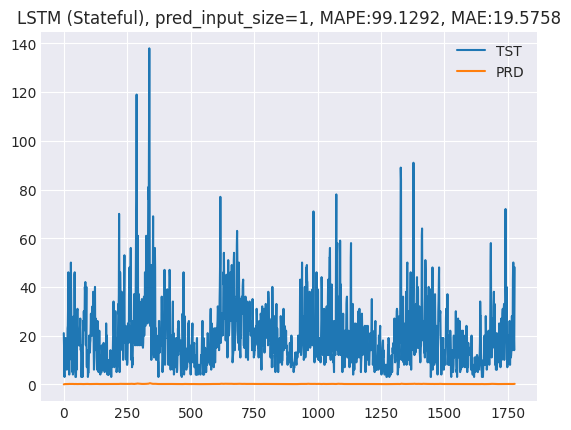

In [26]:
# prd = scaler.inverse_transform(p.cpu())[:, 17:18]
prd = output.detach().cpu()
tst_data = trn.to_numpy()[1:]
plt.title(f"LSTM (Stateful), pred_input_size=1, MAPE:{mape(prd,tst_data):.4f}, MAE:{mae(prd,tst_data):.4f}")
plt.plot(tst_data, label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()

In [63]:
# F.mse_loss(torch.from_numpy(prd),torch.from_numpy(tst_data))
F.mse_loss(prd,torch.from_numpy(tst_data))

/tmp/ipykernel_521108/1678888442.py:2: UserWarning: Using a target size (torch.Size([1779])) that is different to the input size (torch.Size([1778, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(prd,torch.from_numpy(tst_data))


tensor(176.8370, dtype=torch.float64)

1. 이대로 일단 합친다 
2. 코드 상의 문제인지 한번 더 확인한다 -> 선택!